In [ ]:
#Nicolas Cardenas Valdez A01114959
import pandas as pd
import numpy as np

# LIMPIEZA

In [39]:
data=pd.read_csv("iris.csv", index_col="Id")
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [40]:
#El CSV no contiene NA pero sigue siendo bueno filtrarlos
data=data.dropna().copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [41]:
data.duplicated().sum() #Vemos que hay tres duplicados

3

In [42]:
data.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

In [43]:
data.Species.value_counts()

Iris-versicolor    50
Iris-virginica     50
Iris-setosa        50
Name: Species, dtype: int64

# MODELO

In [49]:
#Normalmente hariamos lo siguiente:
#data.join(pd.get_dummies(data.Species,prefix="species-"),how="inner").copy()
#data=data.drop(["Id","Species"],axis=1).copy()

#Sin embargo, lo que queremos decifrar es el tipo de especie, por lo tanto lo tomamos como la variable dependiente
X = data.drop(['Species'], axis = 1)
X.head()

Y = data['Species']

In [79]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y, test_size=0.25,random_state=50)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
Id,,,,
89,5.6,3.0,4.1,1.3
73,6.3,2.5,4.9,1.5
21,5.4,3.4,1.7,0.2
17,5.4,3.9,1.3,0.4
148,6.5,3.0,5.2,2.0
141,6.7,3.1,5.6,2.4
114,5.7,2.5,5.0,2.0
24,5.1,3.3,1.7,0.5
13,4.8,3.0,1.4,0.1


In [67]:
#Usaremos DecisionTreeClassifier debido a que tenemos variables categoricas
from sklearn.tree import DecisionTreeClassifier
modelo = DecisionTreeClassifier(random_state=0)

In [68]:
modelo.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

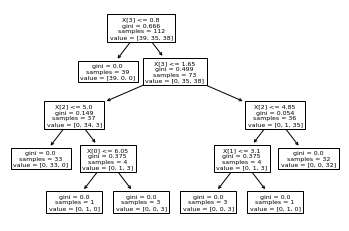

In [71]:
from sklearn import tree
from matplotlib import pyplot as plt
tree.plot_tree(modelo)
plt.show()

# METRICA

In [78]:
from sklearn.metrics import accuracy_score
predicciones=modelo.predict(x_test)
accuracy_score(y_test,predicciones)

0.9473684210526315

Tenemos un excelente accuracy_score lo cual nos indica que nuestro modelo es bueno